In [8]:
from itertools import combinations

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from metrics import tpr, fpr, f1, precision, npv, accuracy, selection_rate
from pipeline import FairDataset, FairPipeline, tpr_score, fpr_score, npv_score, selection_rate_score


dataset_name = 'Synthetic'
sensitive_attribute_name = 'A'
classifiers = {'xgb': xgb.XGBClassifier()}
classifier_config_path = 'configs/classifier_config.yml'
metrics = {
    'tpr': tpr_score,
    'fpr': fpr_score,
    'precision': precision_score,
    'recall': recall_score,
    'npv': npv_score,
    'accuracy': accuracy_score,
    'f1': f1_score,
    'selection_rate': selection_rate_score
}
metric_functions = {
    'tpr': tpr,
    'fpr': fpr,
    'precision': precision,
    'npv': npv,
    'selection_rate': selection_rate
}
global_metrics_map = {
    'f1': f1,
    'precision': precision,
    'npv': npv,
    'accuracy': accuracy,
}
global_metric_setting = 'accuracy'
lambda_list = [0.1, 1.0, 3.0, 5.0, 7.5, 10.0, 20.0]

n_classes = 2
n_features = 15
group_sizes = [500, 500, 500, 500, 500]
class_separation_scores = [0.5, 0.5, 0.5, 0.5, 0.5]
assert(len(group_sizes) == len(class_separation_scores))

results_df_list = []
for num_groups in range(2, len(group_sizes) + 1):
    X_list = []
    y_list = []
    A_list = []
    for group_index, (group_size, separation_score) in enumerate(zip(group_sizes, class_separation_scores)):
        if group_index < num_groups:
            X_group, y_group = make_classification(
                n_samples=group_size, 
                n_features=n_features, 
                n_classes=n_classes, 
                random_state=group_index, 
                class_sep=separation_score
            )
            A_group = np.ones(y_group.shape) * group_index
            
            X_list.append(X_group)
            y_list.append(y_group)
            A_list.append(A_group)

    X = pd.DataFrame(np.vstack(X_list))
    X.columns = [f'X{name}' for name in X.columns]
    y = np.hstack(y_list)
    A = np.hstack(A_list)
    X['A'] = A

    dataset = FairDataset(dataframe=X, target=y, sensitive_attrs=['A'])
    
    pipeline = FairPipeline(
        classifiers=classifiers, 
        classifier_config_path=classifier_config_path, 
        metrics=metrics,
        metric_functions=metric_functions,
        global_metric=global_metrics_map[global_metric_setting],
        lambdas=lambda_list,
        max_error=0.01, 
        max_total_combinations=50000
    )

    pipeline.tune_and_evaluate(
        dataset=dataset, 
        dataset_name=dataset_name, 
        sensitive_attr=sensitive_attribute_name
    )
    results_df = pipeline.results_df
    
    unique_groups = np.unique(dataset.dataframe[sensitive_attribute_name])
    unique_group_pairs = list(combinations(unique_groups, 2))
    sum_epsilons = []
    max_epsilons = []
    mean_epsilons = []
    for best_epsilons_dict in results_df['best_epsilons']:
        if isinstance(best_epsilons_dict, dict):
            epsilons = []
            for reference_group, other_group in unique_group_pairs:
                epsilons.extend(best_epsilons_dict[reference_group][other_group])
        else:
            epsilons = best_epsilons_dict
        sum_epsilons.append(np.sum(epsilons))
        max_epsilons.append(np.max(epsilons))
        mean_epsilons.append(np.mean(epsilons))
    print('-'*80)
    print(num_groups)
    print(sum_epsilons)
    print('-'*80)
    results_df['sum_epsilons'] = sum_epsilons
    results_df['max_epsilon'] = max_epsilons
    results_df['mean_epsilon'] = mean_epsilons
    results_df['num_groups'] = num_groups
    results_df_list.append(results_df)

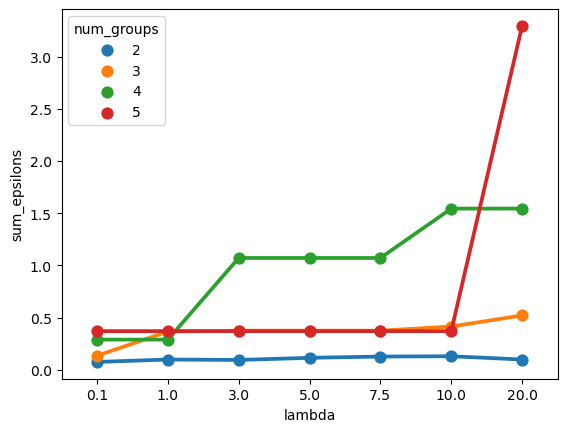

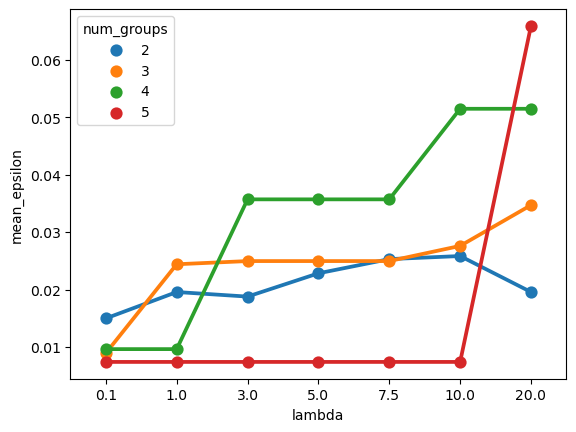

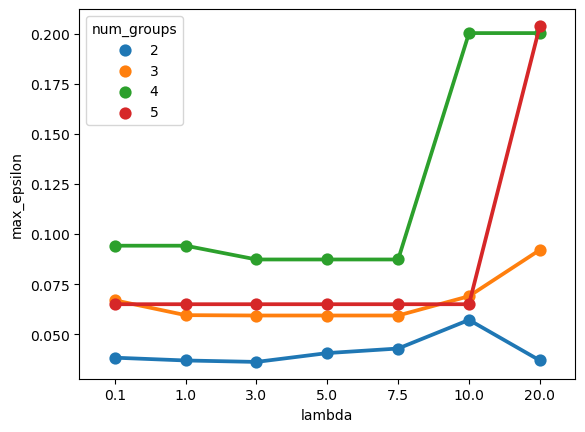

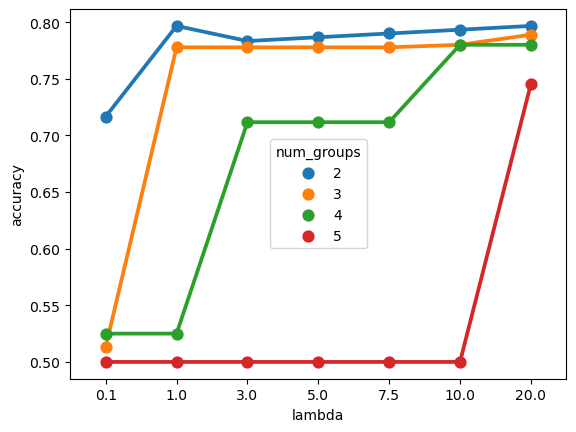

In [141]:
all_results = pd.concat(results_df_list, axis=0)
sns.pointplot(x='lambda', y='sum_epsilons', hue='num_groups', data=all_results[all_results['dataset_subset'] == 'overall'])
plt.show()
sns.pointplot(x='lambda', y='mean_epsilon', hue='num_groups', data=all_results[all_results['dataset_subset'] == 'overall'])
plt.show()
sns.pointplot(x='lambda', y='max_epsilon', hue='num_groups', data=all_results[all_results['dataset_subset'] == 'overall'])
plt.show()
sns.pointplot(x='lambda', y='accuracy', hue='num_groups', data=all_results[all_results['dataset_subset'] == 'overall'])
plt.show()